In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task5/test.csv")
df.drop(columns = ["id", "player_id"], inplace = True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def Plot_All_Histograms(df, bins = 50):
    numeric_cols = df.select_dtypes(include = np.number).columns
    n = len(numeric_cols)

    cols = 6 # number of subplots per row
    rows = int(np.ceil(n / cols))

    plt.figure(figsize = (cols*4, rows*3))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        plt.hist(df[col].dropna(), bins = bins)
        plt.title(col)

    plt.tight_layout()
    plt.show()

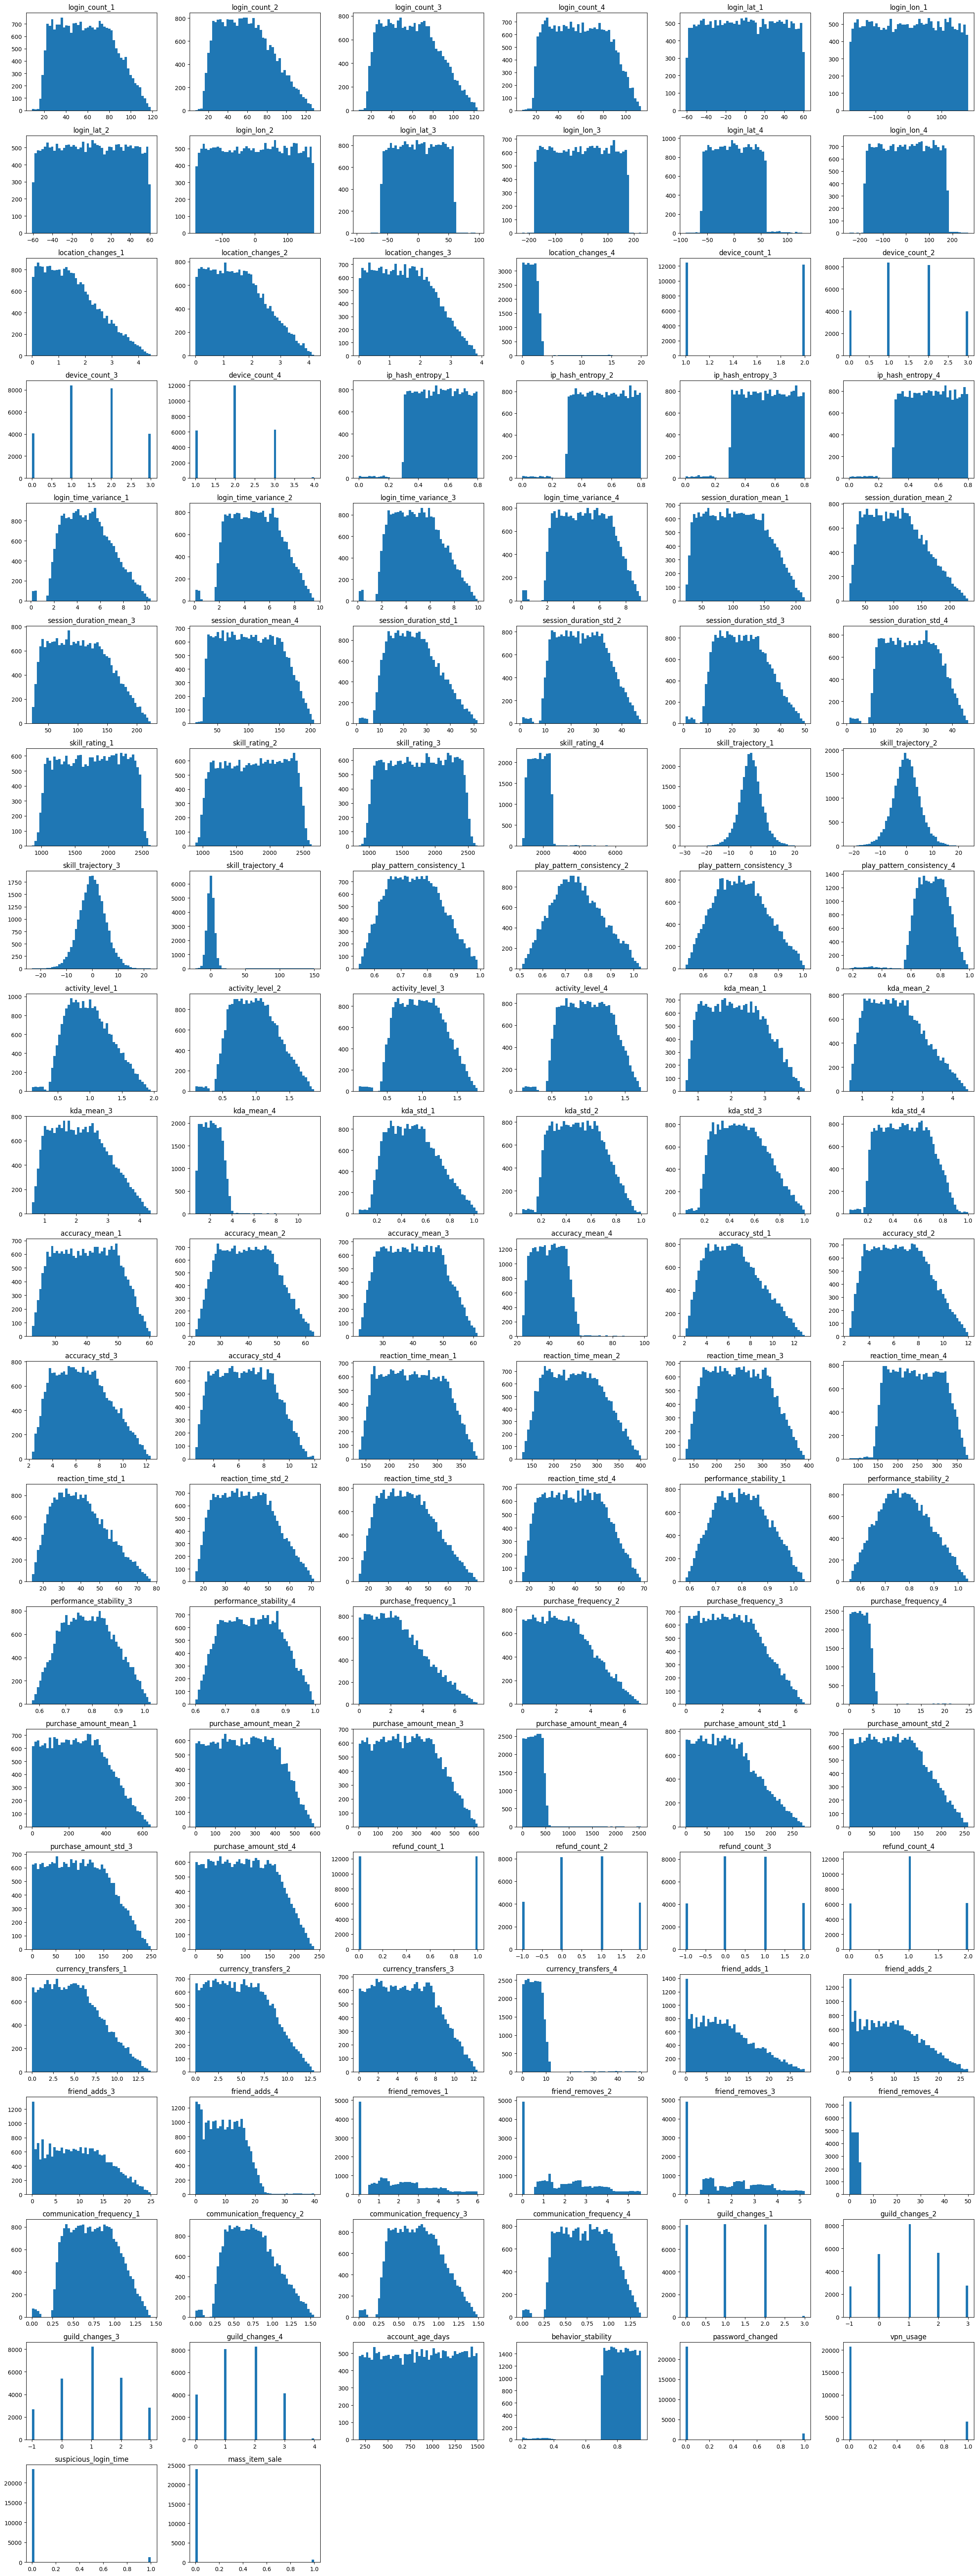

In [3]:
Plot_All_Histograms(df)

# Iterative Imputer

In [4]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor
import numpy as np

def iterative_impute_rf_all_float(
    df,
    n_estimators = 60,
    max_iter = 5,
    random_state = 42,
    n_jobs = -1,
    tol = 1e-3,
    initial_strategy = "mean",
    verbose = True
):
    X = df.values.astype(np.float32)

    lgb = LGBMRegressor(
        n_estimators = n_estimators,
        learning_rate = 0.1,
        num_leaves = 31,
        max_depth = 8,
        subsample = 0.7,
        colsample_bytree = 0.7,
        n_jobs = n_jobs,
        random_state = random_state,
        verbosity = -1
    )

    imputer = IterativeImputer(
        estimator = lgb,
        max_iter = max_iter,
        tol = tol,
        random_state = random_state,
        initial_strategy = initial_strategy,
        imputation_order ="ascending",
        sample_posterior = False
    )

    if verbose:
        print(f"Starting iterative imputation on array shape {X.shape}")
        print(f"Estimator: LGBMRegressor(n_estimators = {n_estimators}, n_jobs = {n_jobs})")
        print(f"max_iter = {max_iter}, tol = {tol}, initial_strategy = {initial_strategy}")


    X_imputed = imputer.fit_transform(X)

    if verbose:
        print("Imputation finished.")

    return pd.DataFrame(X_imputed, columns = df.columns, index = df.index)

In [5]:
imputed = iterative_impute_rf_all_float(df)
print(imputed.head())

Starting iterative imputation on array shape (25889, 122)
Estimator: LGBMRegressor(n_estimators = 60, n_jobs = -1)
max_iter = 5, tol = 0.001, initial_strategy = mean


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Imputation finished.
   login_count_1  login_count_2  login_count_3  login_count_4  login_lat_1  \
0      31.222233      41.790417      28.048735      31.906664   -17.074036   
1      61.359001      49.209286      58.572605      58.594189    48.430878   
2      24.763477      37.723228      26.879627      32.503284     8.252685   
3      82.100746      74.862389      73.520927      83.495308   -28.728292   
4      50.901215      70.636574      55.606358      68.179390   -46.833702   

   login_lon_1  login_lat_2  login_lon_2  login_lat_3  login_lon_3  ...  \
0   127.285637   -17.554811   126.865555   -18.679380   128.290924  ...   
1    25.555742    48.708992    26.733952    48.706074    26.597055  ...   
2    40.788696     8.346856    40.688038     8.630887    40.910034  ...   
3   178.990463   -29.104994   178.810806   -28.198793   180.045700  ...   
4   167.886398   -47.372143   166.767059   -47.828835   167.372513  ...   

   guild_changes_1  guild_changes_2  guild_changes_3  guild

In [6]:
imputed.isna().sum().sum()

0

# Distance-Based

In [7]:
from sklearn.preprocessing import StandardScaler
  
scaler = StandardScaler()

X_std = scaler.fit_transform(imputed)

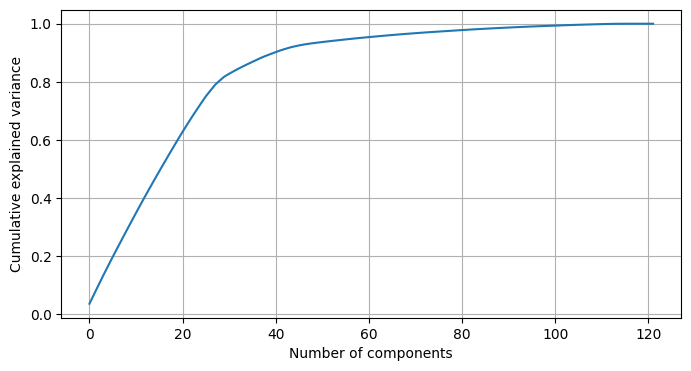

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X_std)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show()

In [9]:
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X_std)

print("Original shape:", X_std.shape)
print("Transformed shape:", X_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)

Original shape: (25889, 122)
Transformed shape: (25889, 59)
Explained variance ratio: [0.03454056 0.03311438 0.03281564 0.03265965 0.03178127 0.03120735
 0.03080335 0.03050608 0.03037582 0.0299842  0.02993516 0.02969263
 0.02915916 0.0285172  0.02840878 0.02814461 0.02775129 0.027566
 0.02714367 0.02691796 0.02647221 0.02571497 0.0251532  0.02442465
 0.02391734 0.02338774 0.02000749 0.01978023 0.01469149 0.01349888
 0.00946189 0.0090335  0.00854989 0.00818893 0.00777127 0.00758101
 0.00751597 0.00747538 0.00651022 0.0060957  0.00596268 0.00584854
 0.00495514 0.00481557 0.00392221 0.00343427 0.00296127 0.00253868
 0.002213   0.00203349 0.00190781 0.0018985  0.00184404 0.00179406
 0.00175959 0.00174053 0.00169776 0.00168524 0.00160413]
Number of components: 59


## Mahalanobis distance

In [10]:
cov = np.cov(X_std, rowvar = False)
invcov = np.linalg.pinv(cov)
mean_vec = X_std.mean(axis = 0)

diff = X_std - mean_vec
m2_full = np.einsum("ij, jk, ik->i", diff, invcov, diff)
m_full = np.sqrt(np.maximum(m2_full, 0.0))

print("Mahalanobis^2: mean = {:.3f}, median = {:.3f}, max = {:.3f}".format(m2_full.mean(), np.median(m2_full), m2_full.max()))

Mahalanobis^2: mean = 121.995, median = 110.544, max = 1562.978


## PCA Whitening

In [11]:
m2_pca = np.sum(X_pca**2, axis = 1)
m_pca = np.sqrt(np.maximum(m2_pca, 0.0))

print("PCA-whitened squared dist: mean = {:.3f}, median = {:.3f}, max = {:.3f}".format(m2_pca.mean(), np.median(m2_pca), m2_pca.max()))

PCA-whitened squared dist: mean = 116.007, median = 110.044, max = 538.533


In [12]:
corr = np.corrcoef(m2_full, m2_pca)[0,1]
print("Correlation between full Mahalanobis^2 and PCA-whitened^2: {:.4f}".format(corr))

Correlation between full Mahalanobis^2 and PCA-whitened^2: 0.6868


## Histrogram Plot

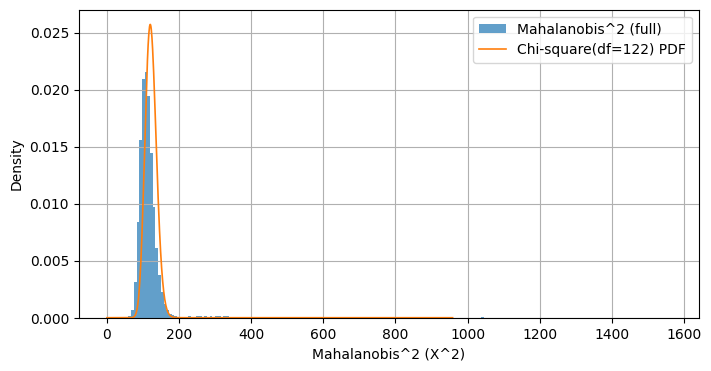

In [13]:
from scipy.stats import chi2

n_samples, n_features = X_std.shape

fig1 = plt.figure(figsize = (8,4))
plt.hist(m2_full, bins = 200, density = True, alpha = 0.7, 
         label = "Mahalanobis^2 (full)", edgecolor = "none")

xs = np.linspace(0, np.percentile(m2_full, 99.9), 1000)
pdf_full = chi2.pdf(xs, df = n_features)
plt.plot(xs, pdf_full, linewidth = 1.2, label = f"Chi-square(df={n_features}) PDF")
plt.xlabel("Mahalanobis^2 (X^2)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

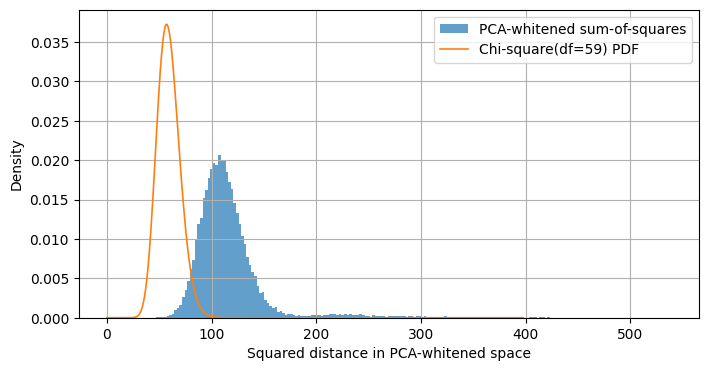

In [14]:
n_components = pca.n_components_

fig2 = plt.figure(figsize = (8,4))
plt.hist(m2_pca, bins = 200, density = True, alpha = 0.7, 
         label = "PCA-whitened sum-of-squares", edgecolor = "none")

xs2 = np.linspace(0, np.percentile(m2_pca, 99.9), 1000)
pdf_pca = chi2.pdf(xs2, df = n_components)
plt.plot(xs2, pdf_pca, linewidth = 1.2, label = f"Chi-square(df={int(n_components)}) PDF")
plt.xlabel("Squared distance in PCA-whitened space")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

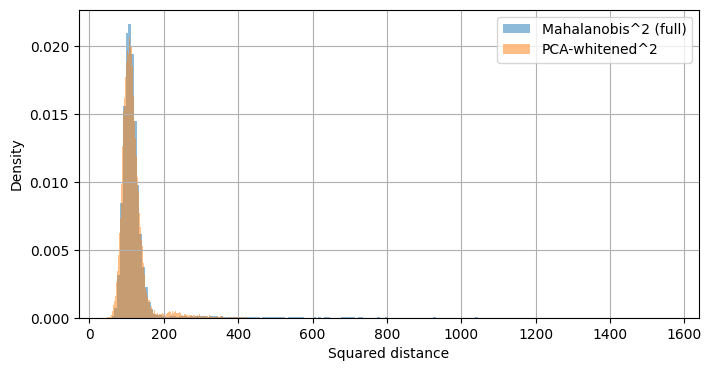

In [15]:
fig3 = plt.figure(figsize=(8,4))
plt.hist(m2_full, bins = 200, density = True, alpha = 0.5, 
         label = "Mahalanobis^2 (full)", edgecolor = "none")
plt.hist(m2_pca, bins = 200, density = True, alpha = 0.5, 
         label = "PCA-whitened^2", edgecolor = "none")

plt.xlabel("Squared distance")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
summary_df = pd.DataFrame({
    "m2_full": m2_full,
    "m2_pca": m2_pca,
    "m_full": m_full,
    "m_pca": m_pca
})

In [17]:
summary_df

,m2_full,m2_pca,m_full,m_pca
0,115.216404,133.295776,10.733890,11.545379
1,102.033108,99.580528,10.101144,9.979004
2,91.244160,81.285004,9.552181,9.015820
3,105.079281,108.582054,10.250819,10.420271
4,107.966653,109.599319,10.390700,10.468969
...,...,...,...,...
25884,102.042676,88.128716,10.101617,9.387690
25885,113.237614,122.036812,10.641316,11.047028
25886,126.633251,148.476501,11.253144,12.185094
25887,117.179480,92.339149,10.824947,9.609326


In [18]:
from scipy.stats import chi2

alpha = 0.0001
k_full = n_features
k_pca = n_components

threshold_full = chi2.ppf(1 - alpha, df = k_full)
threshold_pca = chi2.ppf(1 - alpha, df = k_pca)

summary_df["anomaly_full"] = summary_df["m2_full"] > threshold_full
summary_df["anomaly_pca"]  = summary_df["m2_pca"] > threshold_pca

print(threshold_full, threshold_pca)

188.80302036215423 108.16339913268519


In [19]:
summary_df[["anomaly_full", "anomaly_pca"]].describe()

,anomaly_full,anomaly_pca
count,25889,25889
unique,2,2
top,False,True
freq,25037,13905


## Negate Chi-Distribution Method

In [20]:
from scipy.stats import shapiro

stat, p = shapiro(imputed)
print("Statistics = %f, p = %f" % (stat, p))
if p > 0.05:
    print("Probably Gaussian")
else:
    print("Probably not Gaussian")

Statistics = 0.319834, p = 0.000000
Probably not Gaussian


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 3158458.
  res = hypotest_fun_out(*samples, **kwds)


# Reconstruction Error

In [21]:
X_recon = pca.inverse_transform(X_pca)
reconstruction_error = np.mean(np.abs(X_std - X_recon), axis = 1) # mean absolute error per row

percentile = 99.9  # e.g., top 0.1%
threshold_recon = np.percentile(reconstruction_error, percentile)
anomaly_recon = reconstruction_error > threshold_recon

In [22]:
summary_df = pd.DataFrame({
    "reconstruction_error": reconstruction_error,
    "anomaly_recon": anomaly_recon
})

# Add Mahalanobis² distances (treated as distance scores)
summary_df["mahalanobis_full"] = m2_full
summary_df["mahalanobis_pca"] = m2_pca

print(summary_df.describe())

       reconstruction_error  mahalanobis_full  mahalanobis_pca
count          25889.000000      25889.000000     25889.000000
mean               0.140810        121.995288       116.006546
std                0.021269         71.320369        35.685062
min                0.072113         59.389478        47.095951
25%                0.126943         99.018831        97.228920
50%                0.139293        110.544077       110.043587
75%                0.152339        124.275683       124.591042
max                0.326567       1562.978096       538.532837


In [23]:
summary_df

,reconstruction_error,anomaly_recon,mahalanobis_full,mahalanobis_pca
0,0.126125,False,115.216404,133.295776
1,0.121948,False,102.033108,99.580528
2,0.129837,False,91.244160,81.285004
3,0.134385,False,105.079281,108.582054
4,0.149905,False,107.966653,109.599319
...,...,...,...,...
25884,0.132760,False,102.042676,88.128716
25885,0.142723,False,113.237614,122.036812
25886,0.142802,False,126.633251,148.476501
25887,0.173160,False,117.179480,92.339149


## Checklist

### 1. Scatter plot (Mahalanobis vs PCA distance)
Shows agreement/disagreement.
- diagonal = both strong
- off-diagonal = anomaly only in one method

### 2. Reconstruction error vs PCA distance
Shows "off manifold" anomalies.

### 3. 3D scatter in (m_full, m_pca, recon_error)
Shows clusters or isolated points.

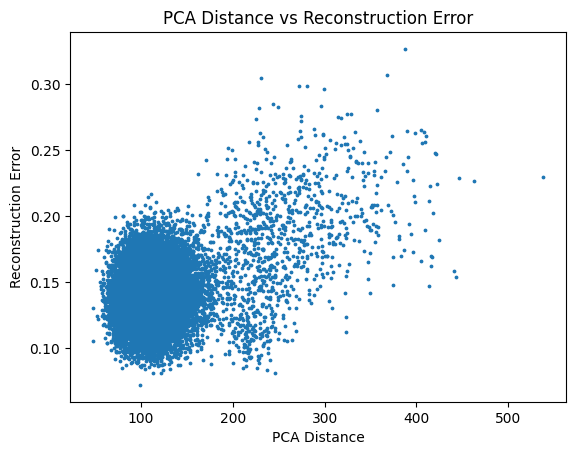

In [24]:
import matplotlib.pyplot as plt

plt.scatter(summary_df["mahalanobis_pca"],
            summary_df["reconstruction_error"],
            s = 3)
plt.xlabel("PCA Distance")
plt.ylabel("Reconstruction Error")
plt.title("PCA Distance vs Reconstruction Error")
plt.show()


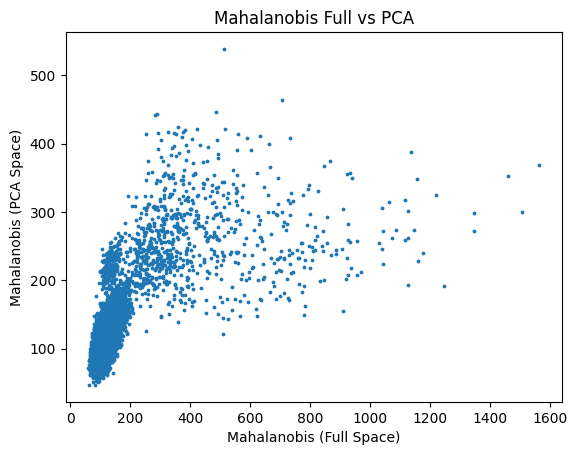

In [25]:
plt.scatter(summary_df["mahalanobis_full"],
            summary_df["mahalanobis_pca"],
            s = 3)
plt.xlabel("Mahalanobis (Full Space)")
plt.ylabel("Mahalanobis (PCA Space)")
plt.title("Mahalanobis Full vs PCA")
plt.show()

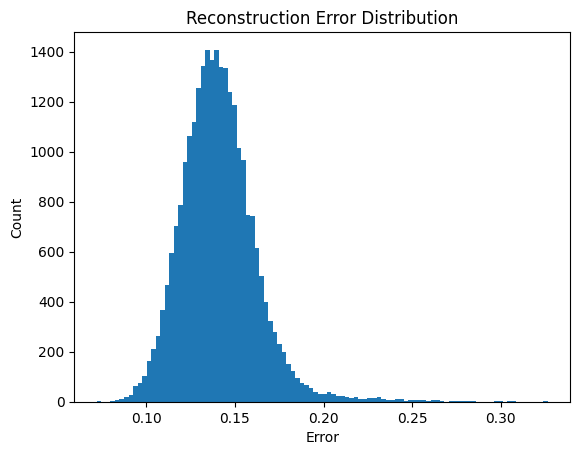

In [26]:
plt.hist(summary_df["reconstruction_error"], bins = 100)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

# Inference

In [27]:
summary_df["score_pca"] = summary_df["mahalanobis_pca"].rank(pct = True)
summary_df["score_full"] = summary_df["mahalanobis_full"].rank(pct = True)
summary_df["score_recon"] = summary_df["reconstruction_error"].rank(pct = True)

In [28]:
# summary_df["anomaly_score_average"] = (
#     summary_df["score_pca"] +
#     summary_df["score_full"] +
#     summary_df["score_recon"]
# ) / 3

# or

summary_df["anomaly_score_max"] = summary_df[[
    "score_pca","score_full","score_recon"
]].max(axis = 1)

In [29]:
cut = summary_df["anomaly_score_max"].quantile(0.85)
summary_df["anomaly_1_max"] = summary_df["anomaly_score_max"] > cut

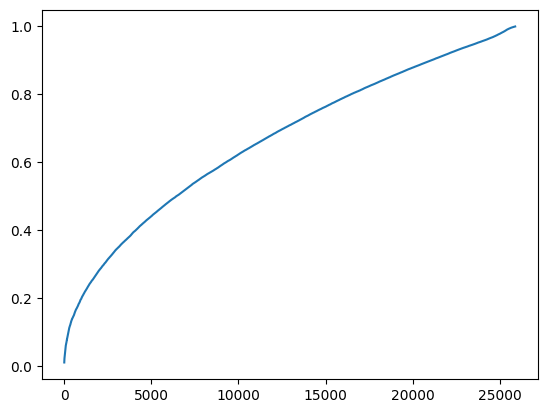

In [30]:
scores = np.sort(summary_df["anomaly_score_max"])
plt.plot(scores)

In [31]:
summary_df["anomaly_1_max"].describe()

count     25889
unique        2
top       False
freq      22007
Name: anomaly_1_max, dtype: object

In [32]:
summary_df["submit"] = summary_df["anomaly_1_max"].astype(int)

In [33]:
summary_df["submit"].to_csv("Test_max2.csv", index = False)